# Imports and hyperparameters

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random

import sys
import gc

import optuna
import logging

from pso_utils import *

In [2]:
# landscape and fitness functions

class Landscape:

    def __init__(self, name, func, minima):
        self.name = name
        self.func = func
        self.minima = minima
    
    def modify_minima(self, new_minima):
        self.func = fitness_decorator(self.func, new_minima[0] - self.minima[0])
        self.minima = new_minima


In [3]:
# hyperparameters

SWARM_SIZE = 1000
ITERATIONS = 100

# Utils

# Fitness functions

**Modifications of fitness functions**:
- translations: to change the minima; to translate in direction $(x', y')$ give as input $(x-x', y-y')$.
- scale of the variables: to change the scale of the problem and the size of the convex regions 
- combination of the two by doing $(x - x') * x_{scale}$

In [4]:
# fitness function modifier

def fitness_decorator(fit, var_translation, var_scale=1, amplitude=1, intercept=0):
    """var_translation and var_scale have (2,) shape"""
    def modified_fit(solutions):
        solutions = solutions - var_translation
        solutions = solutions * var_scale

        return amplitude * fit(solutions) + intercept
    
    return modified_fit

We look for functions with one global minima. They can have only one minima or multiple local minima.
Functions:
- circle
- rastrigin
- 

In [5]:
basic_landscapes = [
    Landscape('circle', circle, np.array([[0, 0]])),
    Landscape('rastrigin', rastrigin, np.array([[0, 0]])),
    Landscape('schaffer', schaffer, np.array([[0, 0]])),
    Landscape('rosenbrock', rosenbrock, np.array([[0, 0]])),
    Landscape('easom', easom, np.array([[0, 0]])),
    Landscape('griewank', griewank, np.array([[0, 0]]))
]

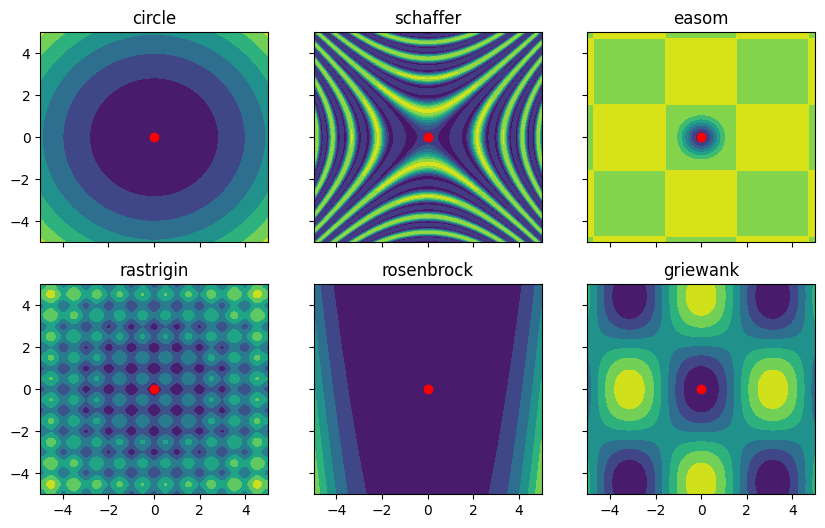

In [6]:
# plot all landscapes

lim = 5
x = np.linspace(-lim, lim, 1000)
y = np.linspace(-lim, lim, 1000)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
pts = np.array([X_flat,Y_flat]).T.copy()

fig, axs = plt.subplots(2, 3, figsize=(10, 6), sharex=True, sharey=True)

for i in range(6):
    landscape = basic_landscapes[i]
    fit = landscape.func((pts))
    ax = axs[i%2, i//2]
    ax.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
    ax.scatter(landscape.minima[0, 0], landscape.minima[0, 1], color='red', )
    ax.set_title(landscape.name)

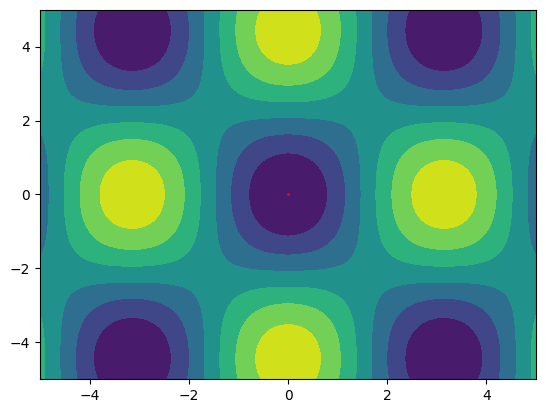

In [7]:
# plot single landscape

lim = 5
x = np.linspace(-lim, lim, 1000)
y = np.linspace(-lim, lim, 1000)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
pts = np.array([X_flat,Y_flat]).T.copy()
fit = griewank(pts)
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)

plt.scatter(0, 0, color='red', marker='*', s=1) # -959.64066271

# Swarm class

In [8]:
# # new version of velocity udate

# def val_up(
#         swarm,
#         velocity,
#         inertia_weight,
#         soc_factor,
#         cog_factor,
#         global_best,
#         personal_best,
#         inertia_decay,
#         ):
#     pass

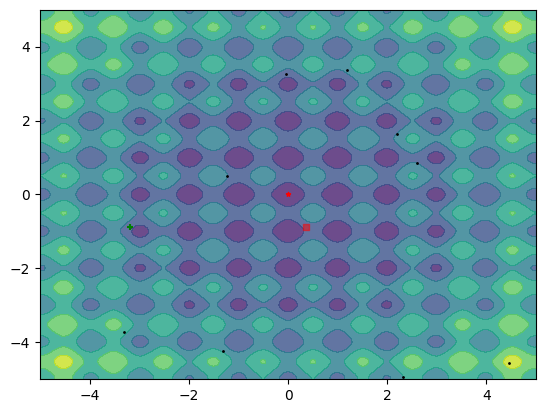

In [9]:
S = Swarm(10, rastrigin)


lim = 5
x = np.linspace(-lim, lim, 1000)
y = np.linspace(-lim, lim, 1000)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
pts = np.array([X_flat,Y_flat]).T.copy()
fit = rastrigin(pts)
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=0.8)

plt.scatter(0, 0, color='red', marker='*', s=9) # -959.64066271
S.plot()

In [10]:
S.generate(1)
S.describe()

best fit value = 19.857311404066465
best solution = [-2.72908916 -0.97198308]
center of mass = [-1.35032611 -0.61832416]
dispersion = 2.280425379604938


(-5.0, 5.0)

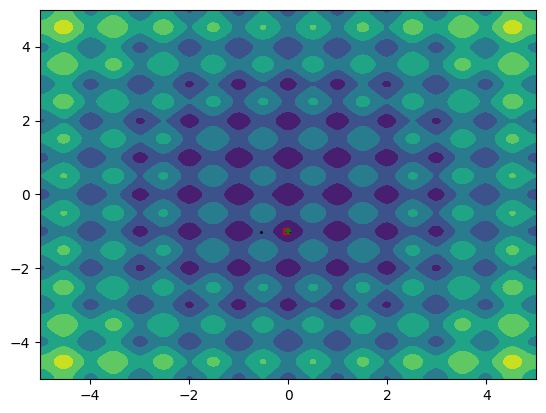

In [11]:
S.generate(10)
lim = 5
x = np.linspace(-lim, lim, 1000)
y = np.linspace(-lim, lim, 1000)
X, Y = np.meshgrid(x, y)
X_flat, Y_flat = X.flatten(), Y.flatten()
pts = np.array([X_flat,Y_flat]).T.copy()
fit = rastrigin(pts)
plt.contourf(Y, X, fit.reshape(1000, 1000).T, alpha=1)
S.plot()
plt.xlim(-5, 5)
plt.ylim(-5, 5)

# Benchmark

We start with just one class of problems (e.g. rastrigin) and try to create a program for this class. Later will be extended to multiple classes. We will generate our solutions only in the [-5, 5] range and move the center in the [-2, 2] of the function. Later we can introduce also scaling of variables and scaling of outputs. But first we only deal with translation.

Paper arrpoach:
- 10 random problems with minima positioned randomly in $[-G, G]^2$ with G=1 or G=2.
- 10 particles, 30 iterations each
- initial coordinates drawn randomly in $[-5, 5]^2$ and velocities set to zero
- for each problem the PSO was run 5 times with initial random configuration
- velocities constrained in [-2, 2]

In [12]:
SWARM_SIZE = 50 # increase time x2
NUM_ITERATIONS = 100 # increase time x2
TRUE_BEST = np.array([[0, 0]])

In [13]:
S = Swarm(SWARM_SIZE, fit=rastrigin)
S.generate(NUM_ITERATIONS)

best fit value = 3.5534517550672717e-06
best solution = [-3.31714966e-05  1.29656894e-04]
center of mass = [0.00036184 0.00050739]
dispersion = 0.00574317690661591


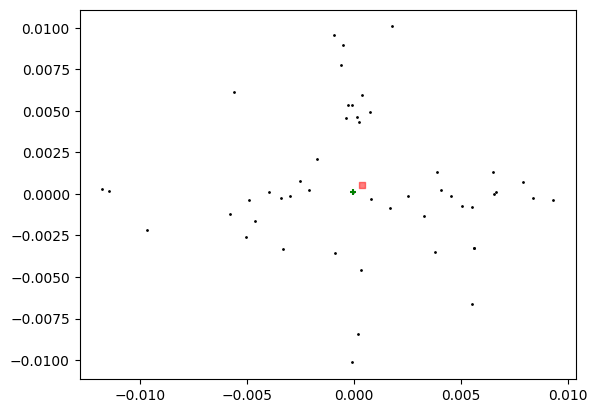

In [14]:
S.plot()
S.describe()

In [15]:
def GPFitness(soc_factor=1.49, cog_factor=1.49, inertia_weight=0.9, inertia_decay=0.99, inertia_min=0):

    num_problems = 100
    t = 5
    problems_minima = np.zeros((100*t, 2))
    problems = []

    for i in range(num_problems):
        land = random.choice(basic_landscapes)

        # Create a new instance of the chosen landscape to avoid decoratros mess
        land = Landscape(land.name, land.func, land.minima.copy())
        new_minima = np.random.uniform(-2, 2, size=(2,))
        land.modify_minima(new_minima)

        problems_minima[i*t: i*t+t] = new_minima

        for _ in range(t):
            problems.append(land)

    raw_results = np.zeros(len(problems))
    results = np.zeros(num_problems)
    swarms_record = []
    best_record = np.zeros((len(problems), 2))

    for i in range(len(problems)):
        land = problems[i]
        S = Swarm(SWARM_SIZE, land.func, soc_factor, cog_factor, inertia_weight, inertia_decay, inertia_min)
        S.generate(NUM_ITERATIONS)
        best_record[i] = S.global_best
        swarms_record.append(S)

    # Clear problems to release memory: OLD
    # del problems
    # gc.collect()

    # Process results
    raw_results = distance(best_record, problems_minima)
    results = raw_results.reshape((-1, 5)).mean(axis=1)

    return results


In [16]:
def GPFitness(soc_factor=1.49, cog_factor=1.49, inertia_weight=0.9, inertia_decay=0.99, inertia_min=0):

    num_problems = 500
    problems_minima = np.zeros((num_problems, 2))
    problems = []

    for i in range(num_problems):
        land = random.choice(basic_landscapes)

        # Create a new instance of the chosen landscape to avoid decoratros mess
        land = Landscape(land.name, land.func, land.minima.copy())
        new_minima = np.random.uniform(-2, 2, size=(2,))
        land.modify_minima(new_minima)

        problems_minima[i] = new_minima
        problems.append(land)


    results = np.zeros(num_problems)
    swarms_record = []
    best_record = np.zeros((len(problems), 2))

    for i in range(len(problems)):
        land = problems[i]
        S = Swarm(SWARM_SIZE, land.func, soc_factor, cog_factor, inertia_weight, inertia_decay, inertia_min)
        S.generate(NUM_ITERATIONS)
        best_record[i] = S.global_best
        swarms_record.append(S)

    # Clear problems to release memory: OLD
    # del problems
    # gc.collect()

    # Process results
    results = distance(best_record, problems_minima)

    return results


In [17]:
results = GPFitness(soc_factor=1.49, cog_factor=1.49, inertia_weight=0.9, inertia_decay=0.01, inertia_min=0)

In [18]:
results.mean(), results.min(), results.max()

(1.9593161456371908, 0.003101699593916881, 12.89409928842206)

In [19]:
np.median(results), np.std(results)

(1.376683699922438, 1.9248144745576306)

# Hyperparameter optimization

In [20]:
def objective(trial):
    soc_factor = trial.suggest_float('soc_factor', 0, 5)
    cog_factor = trial.suggest_float('cog_factor', 0, 5)
    inertia_weight = trial.suggest_float('inertia_weight', 0, 5)
    inertia_decay = trial.suggest_float('inertia_decay', 0, 1)
    inertia_min = trial.suggest_float('inertia_min', 0, 5)

    results = GPFitness(soc_factor, cog_factor, inertia_weight, inertia_decay, inertia_min)

    return float(np.median(results) + np.std(results))

In [21]:
# optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "optimization_folder/pso_standard_additive_new"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, direction="minimize", load_if_exists=True)
study.optimize(objective, n_trials=100, )

[I 2024-12-05 10:39:55,071] A new study created in RDB with name: optimization_folder/pso_standard_additive_new
[I 2024-12-05 10:40:01,972] Trial 0 finished with value: 5.007843577839253 and parameters: {'soc_factor': 3.265679316789583, 'cog_factor': 2.197413311226169, 'inertia_weight': 3.332117115406744, 'inertia_decay': 0.7525896800404185, 'inertia_min': 2.3184544981378807}. Best is trial 0 with value: 5.007843577839253.
[I 2024-12-05 10:40:08,872] Trial 1 finished with value: 5.959645253076149 and parameters: {'soc_factor': 2.0962622716219013, 'cog_factor': 4.0571353053893064, 'inertia_weight': 0.6441582604570562, 'inertia_decay': 0.6205835705006646, 'inertia_min': 4.770466908418382}. Best is trial 0 with value: 5.007843577839253.
[I 2024-12-05 10:40:15,855] Trial 2 finished with value: 3.746514728456838 and parameters: {'soc_factor': 4.583436907353868, 'cog_factor': 3.376432680504224, 'inertia_weight': 0.2924903293593051, 'inertia_decay': 0.7653592558767314, 'inertia_min': 0.099699

In [23]:
study.best_params

{'soc_factor': 4.009960200604314,
 'cog_factor': 3.473738191757937,
 'inertia_weight': 0.6919586572533245,
 'inertia_decay': 0.48697654175381877,
 'inertia_min': 0.5688806944106813}

In [76]:
land = basic_landscapes[0]
land.modify_minima(np.array([[-1, 1]]))

In [77]:
S = Swarm(SWARM_SIZE, fit=land.func,**study.best_params)

best fit value = 9.364568342620102e-06
best solution = [-0.99857044  0.99729428]
center of mass = [-0.95817691  1.46651388]
dispersion = 2.1197144741292893


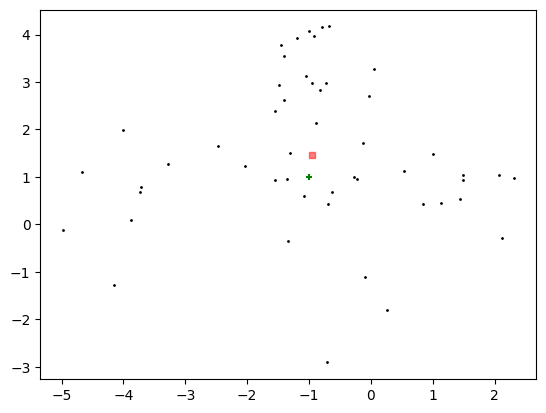

In [91]:
S.generate(100)
S.plot()
S.describe()